In [1]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy

#Import some image analysis functions
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf

import sys

##################################################################################################
# CHANGE THIS TO THE PATH WHERE THE DDM CODE IS (GET FROM GITHUB IF YOU HAVEN'T YET)             #
path_to_ddm_code = "C:\\Users\\rmcgorty\\Documents\\GitHub\\Differential-Dynamic-Microscopy---Python\\"
##################################################################################################

sys.path.append(path_to_ddm_code)
import radiav
import tiff_file
import ddm_clean as ddm

C:\Users\rmcgorty\Documents\GitHub\Differential-Dynamic-Microscopy---Python\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
C:\Users\rmcgorty\Documents\GitHub\Differential-Dynamic-Microscopy---Python\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
C:\Users\rmcgorty\Documents\GitHub\Differential-Dynamic-Microscopy---Python\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
%matplotlib notebook

Imports not working? Make sure to grab the [DDM repository from GitHub](https://github.com/rmcgorty/Differential-Dynamic-Microscopy---Python). 

Don't know what all those scipy.ndimage functions are? [Check out the documentation](https://docs.scipy.org/doc/scipy/reference/ndimage.html). 

In [3]:
def im_corr(image, filter=False, filtersize=80):
    '''
    This function computes the image correlation. 
    Inputs:
        image - the 2D matrix of the image
        filter (optional) - boolean, defaults to False. Whether or not to filter image using the uniform filter
        filtersize (optional) - defaults to 80. Size of filter
    Outputs:
        corr_im - the correlation (same size as input image)
        rav_corr - radially averaged correlation
    '''
    
    #If the 'filter' optional argument is true, then filter the image
    if filter:
        image = filtimage(image, filtersize = filtersize)
        
    #Subtract of the mean and divide by standard deviation (so that the maximum
    #  of the correlation function will be 1)
    image = 1.0*image-image.mean()
    image = image/image.std()
    
    #Use Fourier transforms to calculate the correlation
    corr_im = abs(fftshift(ifft2(fft2(image)*np.conj(fft2(image)))))/(image.shape[0]*image.shape[1])
    
    #Compute radial average
    rav_corr = ddm.newRadav(corr_im)
    
    
    return corr_im, rav_corr

def filtimage(image, filtersize=80):
    '''
    Filters image using the scipy.ndimage function uniform_filter
    '''
    image = image*1.0 - uf(image,filtersize)
    return image

In [190]:
movie_num = 5
#data_trial = 10
shear_rate = 10

#Set directory where to find the data:
main_data_dir = "Y:\\Dennis Terwilliger\\Data\\2020-10-29\\Temperature Ramps %iHz\\" % shear_rate
data_dir = "Temp Ramp_%iHz_(23-34Deg)20x\\Temp Ramp_%iHz_(23-34Deg)20x_%i\\" % (shear_rate, shear_rate, movie_num)

#Set the data filename
if shear_rate == 2:
    data_file = "Temp Ramp_%iHz_(34-23Deg)20x_%i_MMStack_Default.ome.tif" % (shear_rate-1, movie_num)
else:
    data_file = "Temp Ramp_%iHz_(23-34Deg)20x_%i_MMStack_Default.ome.tif" % (shear_rate, movie_num)

In [191]:
frame_num = 1000
full_filenm = main_data_dir+data_dir+data_file
im = tiff_file.imread(full_filenm, key=frame_num)
if im.ndim == 2:
    print("Shape of ims is %i,%i" % im.shape)
elif im.ndim == 3:
    print("You'll need to get just one slice (needs a 2D image).")

Shape of ims is 492,656


<IPython.core.display.Javascript object>


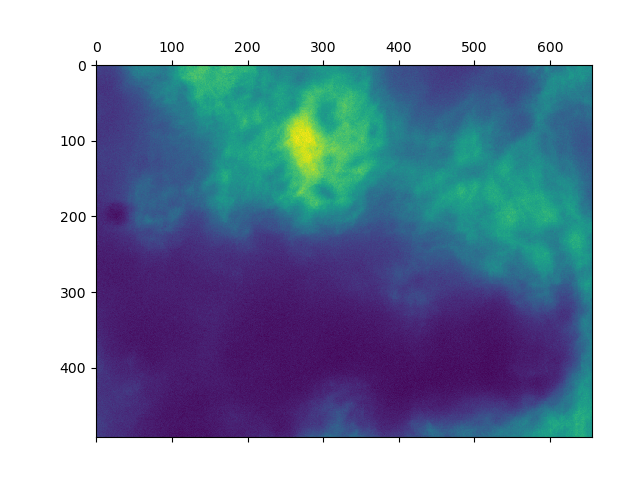

In [192]:
plt.matshow(im)

<IPython.core.display.Javascript object>


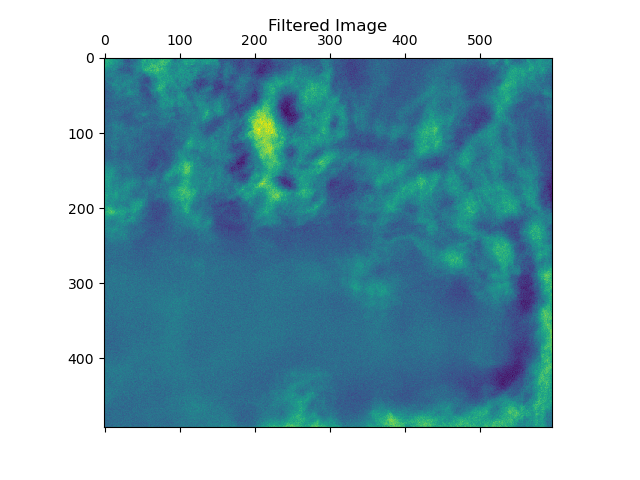

Text(0.5, 1.05, 'Filtered Image')

In [193]:
im_filt = filtimage(im, filtersize=100)
plt.figure()
plt.matshow(im_filt[:,60:], fignum=0)
plt.title("Filtered Image")

In [194]:
corr_im, corr_rad = im_corr(im[:,60:],filter=True,filtersize=100)

<IPython.core.display.Javascript object>


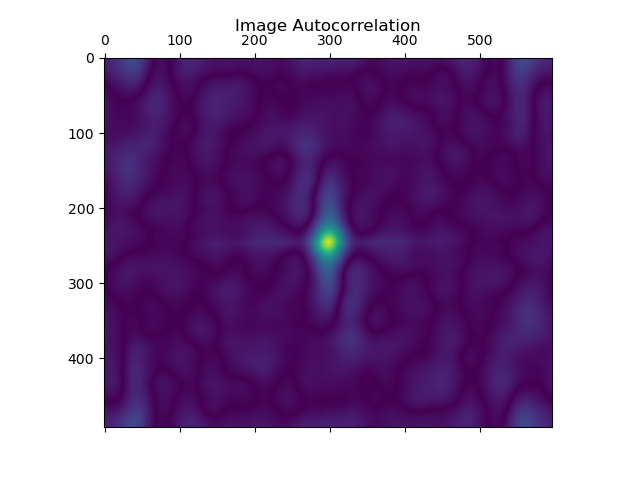

Text(0.5, 1.05, 'Image Autocorrelation')

In [195]:
plt.figure()
plt.matshow(corr_im, fignum=0)
plt.title("Image Autocorrelation")

Look at the image correlation. Does it make sense to take the radially average?

<IPython.core.display.Javascript object>


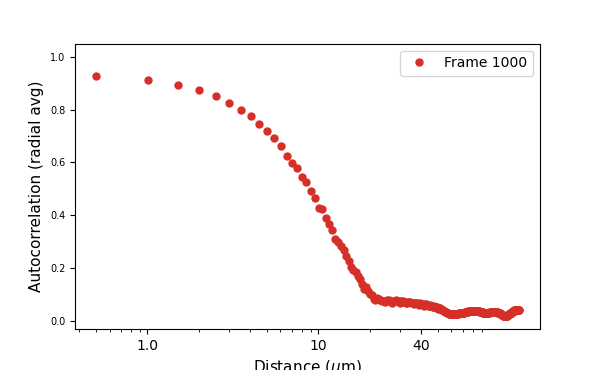

[Text(0, 0, '1.0'), Text(0, 0, '10'), Text(0, 0, '40')]

In [196]:
#Here, we plot the radially average.
#Note that it may make no sense to take the radial average if we don't have radial symmetry

cmap = matplotlib.cm.get_cmap('RdYlBu')

figsize = 6.0
fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
xvalues = np.arange(len(corr_rad))*0.501 #For the rheometer microscope with 20x objective pixel size is 0.501um
ax.tick_params(axis='both', which='major', labelsize=7)
markerSize = 10
plt.semilogx(xvalues, corr_rad,'.',ms=markerSize,c=cmap(0.1),label="Frame 1000")
plt.xlabel("Distance ($\mu$m)",fontsize=11)
plt.ylabel("Autocorrelation (radial avg)",fontsize=11)
plt.legend(loc=0,fontsize=10)


ax.set_xticks([1.0, 10, 40])
ax.set_xticklabels(['1.0','10','40'], fontsize=10)


<IPython.core.display.Javascript object>


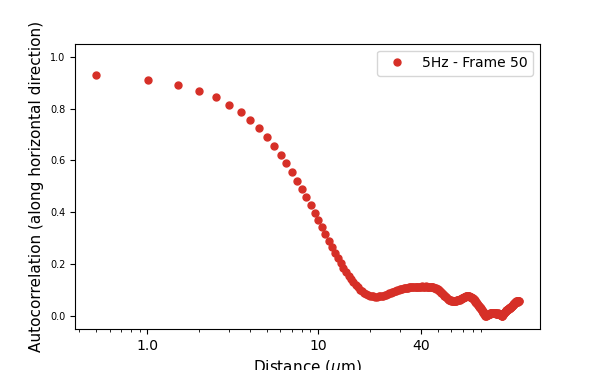

[Text(0, 0, '1.0'), Text(0, 0, '10'), Text(0, 0, '40')]

In [197]:
#Here, we plot a *horizontal* slice through the image autocorrelation.
#Note that it may make no sense to take the radial average if we don't have radial symmetry

cmap = matplotlib.cm.get_cmap('RdYlBu')

nx,ny = corr_im.shape
x_mid = int(nx/2); y_mid = int(ny/2)

figsize = 6.0
fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
xvalues = np.arange(y_mid+1)*0.501 #For the rheometer microscope with 20x objective pixel size is 0.501um
ax.tick_params(axis='both', which='major', labelsize=7)
markerSize = 10
plt.semilogx(xvalues, np.flip(corr_im[x_mid, 0:y_mid+1]),'.',ms=markerSize,c=cmap(0.1),label="5Hz - Frame 50")
plt.xlabel("Distance ($\mu$m)",fontsize=11)
plt.ylabel("Autocorrelation (along horizontal direction)",fontsize=11)
plt.legend(loc=0,fontsize=10)


ax.set_xticks([1.0, 10, 40])
ax.set_xticklabels(['1.0','10','40'], fontsize=10)

<IPython.core.display.Javascript object>


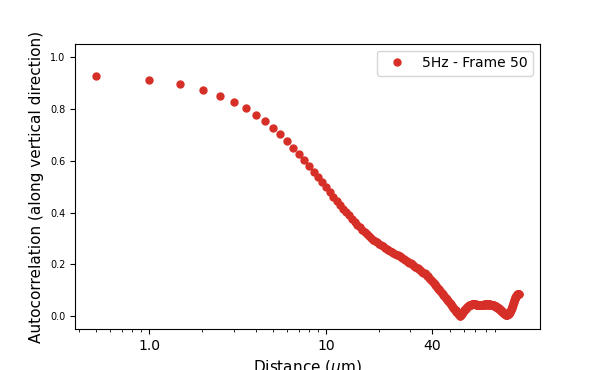

[Text(0, 0, '1.0'), Text(0, 0, '10'), Text(0, 0, '40')]

In [198]:
#Here, we plot a *horizontal* slice through the image autocorrelation.
#Note that it may make no sense to take the radial average if we don't have radial symmetry

cmap = matplotlib.cm.get_cmap('RdYlBu')

nx,ny = corr_im.shape
x_mid = int(nx/2); y_mid = int(ny/2)

figsize = 6.0
fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
xvalues = np.arange(x_mid+1)*0.501 #For the rheometer microscope with 20x objective pixel size is 0.501um
ax.tick_params(axis='both', which='major', labelsize=7)
markerSize = 10
plt.semilogx(xvalues, np.flip(corr_im[0:x_mid+1, y_mid]),'.',ms=markerSize,c=cmap(0.1),label="5Hz - Frame 50")
plt.xlabel("Distance ($\mu$m)",fontsize=11)
plt.ylabel("Autocorrelation (along vertical direction)",fontsize=11)
plt.legend(loc=0,fontsize=10)


ax.set_xticks([1.0, 10, 40])
ax.set_xticklabels(['1.0','10','40'], fontsize=10)

In [199]:
x = np.arange(-1*corr_im.shape[1]/2, corr_im.shape[1]/2, 1)
y = np.arange(-1*corr_im.shape[0]/2, corr_im.shape[0]/2, 1)
xx, yy = np.meshgrid(x, y)
#print("Shape of image corr: ", corr_images[0].shape)
#print("Shape of xx: ", xx.shape)
cos2theta = np.cos(2*np.arctan(1.0*xx/yy))

xc = int(corr_im.shape[0]/2)
yc = int(corr_im.shape[1]/2)
print(xc)

246


<ipython-input-199-106b8b349147>:6: RuntimeWarning: divide by zero encountered in true_divide
  cos2theta = np.cos(2*np.arctan(1.0*xx/yy))
<ipython-input-199-106b8b349147>:6: RuntimeWarning: invalid value encountered in true_divide
  cos2theta = np.cos(2*np.arctan(1.0*xx/yy))


In [200]:
#frames_to_analyze = np.array([70,170,270,370,470,570,670,770,870,970,1070,1170,1270,1370,1470,1570,1670,1770,1870])
frames_to_analyze = np.arange(0,2000,25)
num_frames_to_avg = 10
filtersize=100
every = 2
corr_images = np.zeros((len(frames_to_analyze),492,596),dtype=np.float64)
temp = np.zeros((492,596),dtype=np.float64)
af = np.zeros((len(frames_to_analyze),200),dtype=np.float64)

for i,frames in enumerate(frames_to_analyze):
    for j in range(num_frames_to_avg):
        im = tiff_file.imread(main_data_dir+data_dir+data_file, key=int(frames+(j*every)))
        temp, corr_rad = im_corr(im[:,60:],filter=True,filtersize=filtersize)
        corr_images[i] = corr_images[i] + temp
    corr_images[i] = corr_images[i] / num_frames_to_avg
    
    alignment_factor_numerator, _ = radiav.radav(corr_images[i] * cos2theta, xc, yc, 200)
    alignment_factor_denominator, _ = radiav.radav(corr_images[i], xc, yc, 200)

    af[i] = alignment_factor_numerator / alignment_factor_denominator

<IPython.core.display.Javascript object>


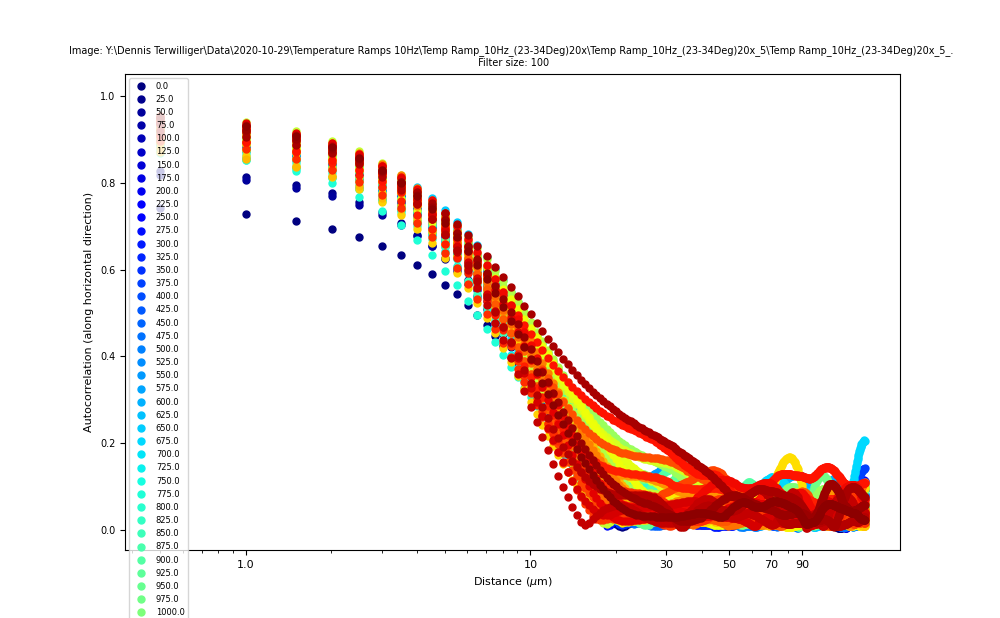

In [201]:
#Here, we plot a *horizontal* slice through the image autocorrelation.

cmap = matplotlib.cm.get_cmap('jet')

nx,ny = corr_images[0].shape
x_mid = int(nx/2); y_mid = int(ny/2)


figsize = 10.0
fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
xvalues = np.arange(y_mid+1)*0.501 #For the rheometer microscope with 20x objective pixel size is 0.501um
ax.tick_params(axis='both', which='major', labelsize=7)
markerSize = 5
mark = 'o'
j=0
for i,frames in enumerate(frames_to_analyze):
    plt.semilogx(xvalues, np.flip(corr_images[i,x_mid, 0:y_mid+1]),mark,ms=markerSize,
                 c=cmap(i/(1.0*len(frames_to_analyze))),label="%.1f" % frames)

plt.xlabel("Distance ($\mu$m)",fontsize=8)
plt.ylabel("Autocorrelation (along horizontal direction)",fontsize=8)
plt.title("Image: %s. \n Filter size: %i" % (main_data_dir+data_dir+data_file[:-23], filtersize), fontsize=7)
plt.legend(loc=0,fontsize=6)


ax.set_xticks([1.0, 10, 30, 50, 70, 90])
ax.set_xticklabels(['1.0','10','30','50','70','90'], fontsize=8)
plt.savefig(main_data_dir+data_dir+data_file[:-23]+"_xcorr.png")

<IPython.core.display.Javascript object>


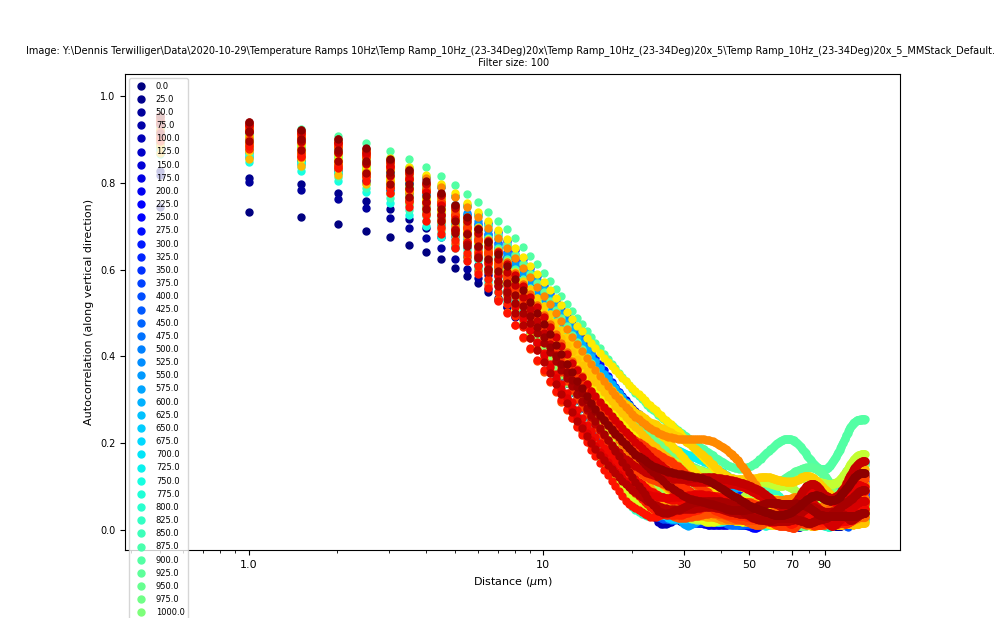

In [202]:
#Here, we plot a *vert* slice through the image autocorrelation.

cmap = matplotlib.cm.get_cmap('jet')

nx,ny = corr_images[0].shape
x_mid = int(nx/2); y_mid = int(ny/2)


figsize = 10.0
fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
xvalues = np.arange(x_mid+1)*0.501 #For the rheometer microscope with 20x objective pixel size is 0.501um
ax.tick_params(axis='both', which='major', labelsize=7)
markerSize = 5
mark = 'o'
j=0
for i,frames in enumerate(frames_to_analyze):
    plt.semilogx(xvalues, np.flip(corr_images[i,0:x_mid+1, y_mid]),mark,ms=markerSize,
                 c=cmap(i/(1.0*len(frames_to_analyze))),label="%.1f" % frames)

plt.xlabel("Distance ($\mu$m)",fontsize=8)
plt.ylabel("Autocorrelation (along vertical direction)",fontsize=8)
plt.title("Image: %s. \n Filter size: %i" % (main_data_dir+data_dir+data_file[:-8], filtersize), fontsize=7)
plt.legend(loc=0,fontsize=6)


ax.set_xticks([1.0, 10, 30, 50, 70, 90])
ax.set_xticklabels(['1.0','10','30','50','70','90'], fontsize=8)
plt.savefig(main_data_dir+data_dir+data_file[:-23]+"_ycorr.png")

<IPython.core.display.Javascript object>


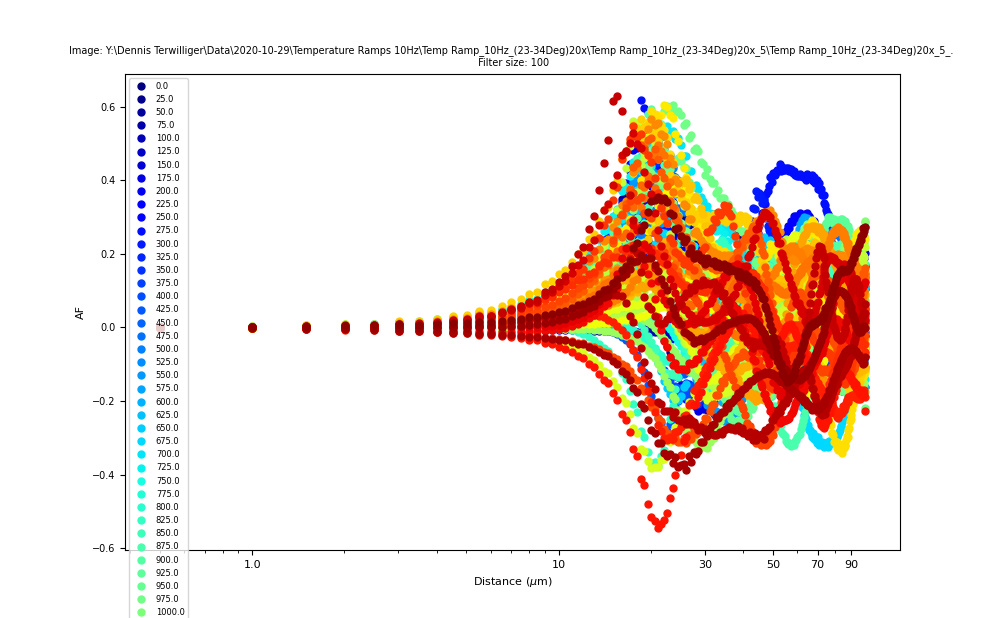

'\nAlignment factor from: Varga, Z. & Swan, J. W. Large scale anisotropies in sheared colloidal gels. \nJournal of Rheology 62, 405–418 (2018).\n\n'

In [203]:
#Here, we plot a *horizontal* slice through the image autocorrelation.

cmap = matplotlib.cm.get_cmap('jet')

nx,ny = corr_images[0].shape
x_mid = int(nx/2); y_mid = int(ny/2)


figsize = 10.0
fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
xvalues = np.arange(200)*0.501 #For the rheometer microscope with 20x objective pixel size is 0.501um
ax.tick_params(axis='both', which='major', labelsize=7)
markerSize = 5
mark = 'o'
j=0
for i,frames in enumerate(frames_to_analyze):
    plt.semilogx(xvalues, af[i],mark,ms=markerSize,
                 c=cmap(i/(1.0*len(frames_to_analyze))),label="%.1f" % frames)

plt.xlabel("Distance ($\mu$m)",fontsize=8)
plt.ylabel("AF",fontsize=8)
plt.title("Image: %s. \n Filter size: %i" % (main_data_dir+data_dir+data_file[:-23], filtersize), fontsize=7)
plt.legend(loc=0,fontsize=6)


ax.set_xticks([1.0, 10, 30, 50, 70, 90])
ax.set_xticklabels(['1.0','10','30','50','70','90'], fontsize=8)
plt.savefig(main_data_dir+data_dir+data_file[:-23]+"_AF.png")

'''
Alignment factor from: Varga, Z. & Swan, J. W. Large scale anisotropies in sheared colloidal gels. 
Journal of Rheology 62, 405–418 (2018).

'''

In [204]:
#Here, we sum the AF up to distance of 20 um (index of 40)

af_upto20 = np.zeros((af.shape[0]))
for i in range(af.shape[0]):
    af_upto20[i] = af[i,1:40].sum()

<IPython.core.display.Javascript object>


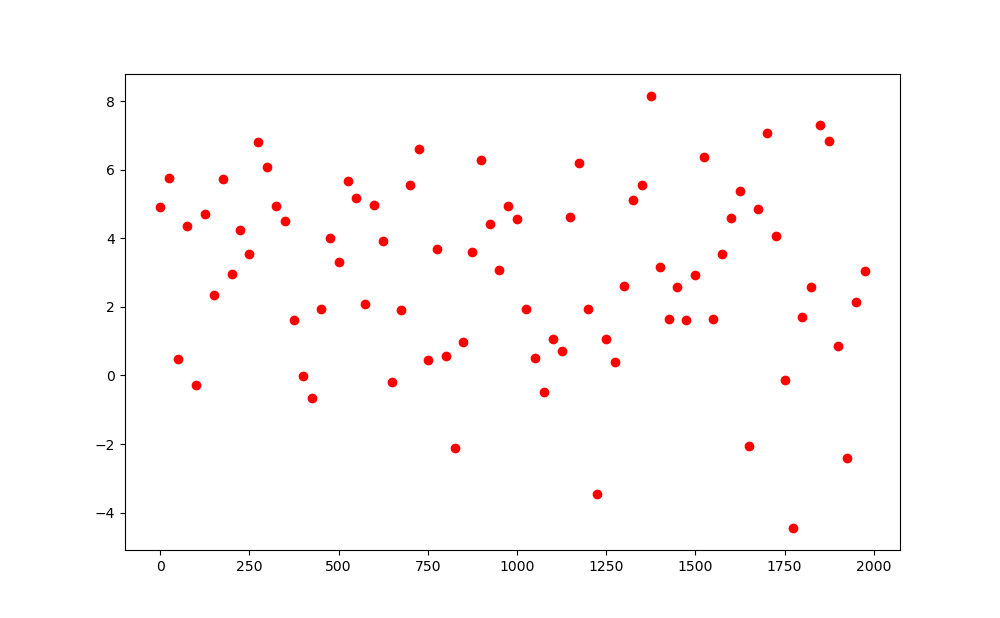

In [205]:
figsize = 10.0
fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
plt.plot(frames_to_analyze, af_upto20,'ro')

In [206]:
dict_to_pickle = {}
dict_to_pickle['data_dir'] = main_data_dir+data_dir+data_file[:-23]
dict_to_pickle['filtersize'] = filtersize
dict_to_pickle['frames_analyzed'] = frames_to_analyze
dict_to_pickle['num_frames_to_avg'] = num_frames_to_avg
dict_to_pickle['every'] = every
dict_to_pickle['corr_images'] = corr_images
dict_to_pickle['af'] = af
dict_to_pickle['af_upto20'] = af_upto20

In [207]:
import pickle

data_dump_file = open(main_data_dir+data_dir+data_file[:-23]+"_pickleddata.p",'wb')
pickle.dump(dict_to_pickle, data_dump_file)
data_dump_file.close()